# Monte Carlo simulation of Ising model

Excercise in course 10122 Statistical Physics

Please see the instructions instead of just running this.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import tikzplotlib
from matplotlib.pyplot import figure
from datetime import datetime
import os as os


Define the functions we will need

In [2]:
def initialize(size, init='random'):
    """Initialize an Ising model.
    
    Parameters:
    size: Size of the system (integer).  The system with be size by size spins.
    init: The value to initialize to.  Default: random spins up or down.
    """
    nx = ny = size
    if init == 'random':
        spin_lattice = np.random.choice([-1,1],size = (nx,ny)) #random spins
    else:
        spin_lattice = init * np.ones((nx, ny), dtype=int)
    return spin_lattice

def ising_energy(state, H=0):
    "Return energy of Ising state."
    return (-np.sum(state*( np.roll(state,1,axis=0) + np.roll(state,1,axis=1) )) 
            -H * np.sum(state))

def simulate(spin_lattice, T, steps=1000, H=0, store_energy=100, store_state=1000):
    """Simulate an Ising model.
    
    Parameters:
    state: The initial state of the system.
    T: Temperature (in units of J).
    steps: Number of steps to run per spin (default 1000).
    H: External magnetic field (default: 0)
    store_energy: How often the energy is stored.
    store_state: How often the state is stored.

    Returns:
    An array of energies, an array of magnetizations, and a list of states.
    """

    # Make a copy of the state, so we don't mess up the initial state
    spin_lattice = np.copy(spin_lattice)
    nx, ny = spin_lattice.shape

    # Steps is given per spin, calculate total number of steps.
    steps *= nx*ny

    #For holding the energy
    E = []
    #For holding the total spin
    M = []
    #For holding states
    S = []

    # Info about initial state
    energy = ising_energy(spin_lattice, H)
    E.append(energy)
    totalspin = spin_lattice.sum()
    M.append(totalspin)
    S.append(np.copy(spin_lattice))

    #initial_spin_lattice = np.copy(spin_lattice) #store the initial state

    for k in range(steps):
            
        #Pick random site to flip
        i = np.random.randint(nx)
        j = np.random.randint(ny)
            
        #Calculate the energy change (periodic boundary condition)
        deltaE = 2*spin_lattice[i,j]*(spin_lattice[(i+1)%nx,j] + spin_lattice[i,(j+1)%ny]
                                    + spin_lattice[(i-1),j] + spin_lattice[i,(j-1)] + H)
        
        #Accept using Metropolis criterion
        if np.random.random() < np.exp(-deltaE/T):
            spin_lattice[i,j] *= -1 #flip the spin
            totalspin += 2*spin_lattice[i,j]
            energy += deltaE
        
        #Every kEM steps, calculate and store the total energy and total spin (periodic boundary condition)
        if np.mod(k,store_energy)==0:
            #Energy
            E.append(energy)
            M.append(totalspin)

        #Every kS steps, store the state
        if store_state and np.mod(k,store_state)==0:
            S.append(np.copy(spin_lattice))
            # Sanity check
            actualenergy = ising_energy(spin_lattice, H)
            assert np.isclose(energy, actualenergy), f'{energy} != {actualenergy}'
            assert totalspin == np.sum(spin_lattice)

            #Display progress through k loop
            print(str(int(k/steps*100))+'% of simulation done', end='\r')

    if not store_state:
        S.append(spin_lattice) # Still return the final state in this case!
    return np.array(E) / (nx*ny), np.array(M) / (nx*ny), S


def plotstate(state, figdim=(12,9)):
    "Plots the state with matplotlib"
    nx, ny = state.shape
    figdim = np.array(figdim) / 2.54  # Convert to inches
    plt.figure(figsize=figdim)
    plt.imshow(state)
    # plt.axis('off')
    plt.ylabel('$x$')
    plt.xlabel('$y$')
    plt.xticks(np.arange(0,ny,5))
    plt.yticks(np.arange(0,nx,5))

### Test what happens at a single temperature
1. Set up the system
2. Run an MC simulation at a given temperature, plot the initial configuration.
3. Make a plot of how important quantities evolve during the simulation.

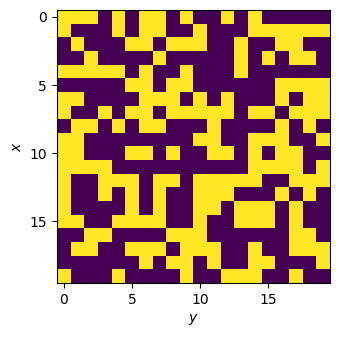

In [14]:
state = initialize(20)
plotstate(state)

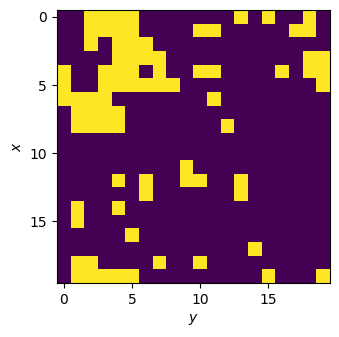

In [16]:
E,M,S = simulate(state, 2.4, store_energy=10)
plotstate(S[-1])

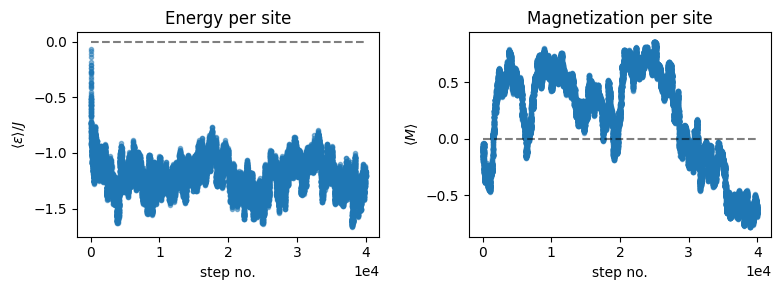

In [17]:
#E = E[::10]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
ax1.plot(np.arange(len(E)), E, '.',alpha=0.5); #plot the energy per spin
ax1.plot(np.array([0,len(E)]),np.array([0,0]),'k--',alpha=0.5) #plot line at 0 for reference
ax1.set_ylabel('$\\langle \\varepsilon \\rangle / J $')
ax1.set_title('Energy per site')

ax2.plot(np.arange(len(M)), M, '.',alpha=0.5); #plot the energy per spin
ax2.plot(np.array([0,len(M)]),np.array([0,0]),'k--',alpha=0.5) #plot line at 0 for reference
ax2.set_ylabel('$\\langle M \\rangle$')
ax2.set_title('Magnetization per site')

for ax in (ax1, ax2):
    ax.set_xlabel('step no.');
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.tight_layout()

### Running simulations at multiple temperatures

This code runs the simulations at multiple temperatures, while collecting information about the energy, the magnetization and their fluctuations.

In [71]:
state = initialize(20,1)
nspins = state.shape[0] * state.shape[1] # Needed for analysis

# temperatures = np.arange(1.0, 5.0, 0.2)
# Make sure temperature points are close near the transition
temperatures = np.concatenate([np.arange(1.0, 2.0, 0.2),
                               np.arange(2.0, 2.5, 0.05),
                               np.arange(2.5,3.0, 0.1),
                               np.arange(3.0, 6.0, 0.5)])
energies = []
energies_std = []
magn = []
magn_std = []
print(f'Simulating temperatures from {temperatures[0]:.2f} to {temperatures[-1]:.2f}.')
for T in temperatures:
    E,M,S = simulate(state, T, store_state=None, steps=2000)
    # Discard first half of data
    E = E[len(E)//2:]
    M = M[len(M)//2:]
    energies.append(E.mean())
    energies_std.append(E.std())
    magn.append(np.abs(M.mean()))
    magn_std.append(M.std())
    print(f'{T:.2f} ', end='')
# Turn it all into numpy arrays
energies = np.array(energies)
energies_std = np.array(energies_std)
magn = np.array(magn)
magn_std = np.array(magn_std)

Simulating temperatures from 1.00 to 5.50.
1.00 1.20 1.40 1.60 1.80 2.00 2.05 2.10 2.15 2.20 2.25 2.30 2.35 2.40 2.45 2.50 2.60 2.70 2.80 2.90 3.00 3.50 4.00 4.50 5.00 5.50 

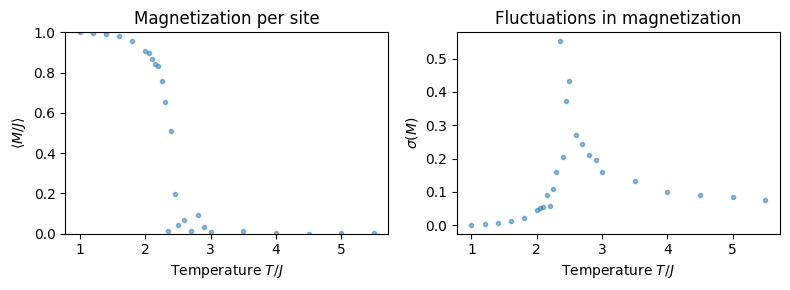

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
ax1.plot(temperatures, magn, '.',alpha=0.5); #plot the energy per spin
#ax1.plot(np.array([0,len(energies)]),np.array([0,0]),'k--',alpha=0.5) #plot line at 0 for reference
ax1.set_ylabel('$\\langle M / J \\rangle $')
ax1.set_title('Magnetization per site')
ax1.set_ylim(0, 1)

ax2.plot(temperatures, magn_std, '.',alpha=0.5); #plot the energy per spin
#ax2.plot(np.array([0,len(magn)]),np.array([0,0]),'k--',alpha=0.5) #plot line at 0 for reference
ax2.set_ylabel('$\\sigma(M)$')
ax2.set_title('Fluctuations in magnetization')

for ax in (ax1, ax2):
    ax.set_xlabel('Temperature $T / J$');
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.tight_layout()

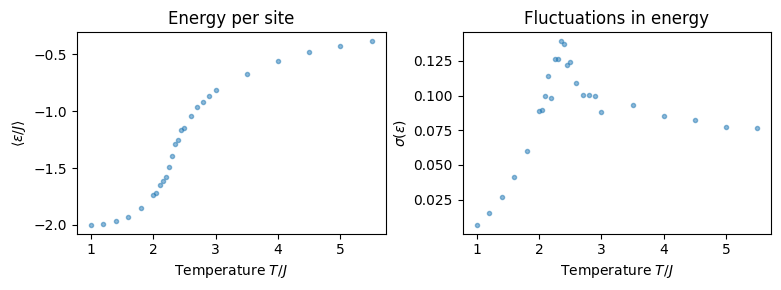

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
ax1.plot(temperatures, energies, '.',alpha=0.5); #plot the energy per spin
#ax1.plot(np.array([0,len(energies)]),np.array([0,0]),'k--',alpha=0.5) #plot line at 0 for reference
ax1.set_ylabel('$\\langle \\varepsilon  / J \\rangle $')
ax1.set_title('Energy per site')

ax2.plot(temperatures, energies_std, '.',alpha=0.5); #plot the energy per spin
#ax2.plot(np.array([0,len(magn)]),np.array([0,0]),'k--',alpha=0.5) #plot line at 0 for reference
ax2.set_ylabel('$\\sigma(\\varepsilon)$')
ax2.set_title('Fluctuations in energy')

for ax in (ax1, ax2):
    ax.set_xlabel('Temperature $T / J$');
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.tight_layout()

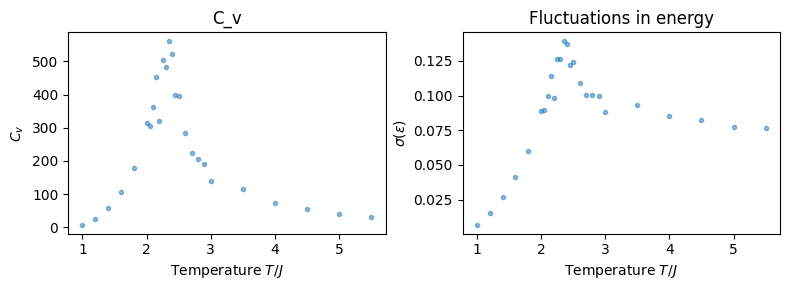

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
cv = (energies_std * nspins / temperatures)**2
ax1.plot(temperatures, cv, '.',alpha=0.5); #plot the energy per spin
#ax1.plot(np.array([0,len(energies)]),np.array([0,0]),'k--',alpha=0.5) #plot line at 0 for reference
ax1.set_ylabel('$C_v$')
ax1.set_title('C_v')

ax2.plot(temperatures, energies_std, '.',alpha=0.5); #plot the energy per spin
#ax2.plot(np.array([0,len(magn)]),np.array([0,0]),'k--',alpha=0.5) #plot line at 0 for reference
ax2.set_ylabel('$\\sigma(\\varepsilon)$')
ax2.set_title('Fluctuations in energy')

for ax in (ax1, ax2):
    ax.set_xlabel('Temperature $T / J$');
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.tight_layout()

### Finite field

In [23]:
state = initialize(40,1)
nspins = state.shape[0] * state.shape[1] # Needed for analysis

fields = [0.01, 0.02, 0.04, 0.08, 0.16]
T=2.269

energies = []
energies_std = []
magn = []
magn_std = []
print(f'Simulating fields from {fields[0]:.2f} to {fields[-1]:.2f}.')
for H in fields:
    E,M,S = simulate(state, T, H=H, store_state=None, steps=4000)
    # Discard first half of data
    E = E[len(E)//2:]
    M = M[len(M)//2:]
    energies.append(E.mean())
    energies_std.append(E.std())
    magn.append(np.abs(M.mean()))
    magn_std.append(M.std())
    print(f'{H:.2f} ', end='')
# Turn it all into numpy arrays
energies = np.array(energies)
energies_std = np.array(energies_std)
magn = np.array(magn)
magn_std = np.array(magn_std)

Simulating fields from 0.01 to 0.16.
0.01 0.02 0.04 0.08 0.16 

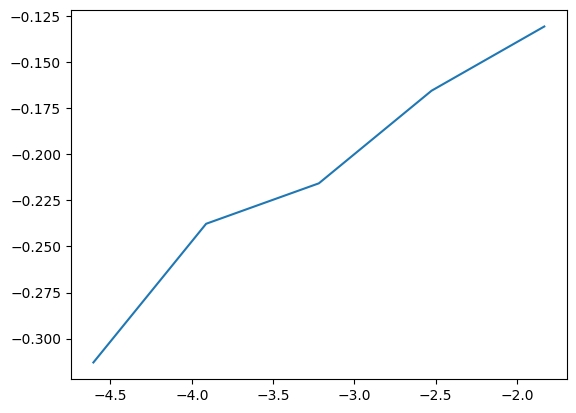

In [24]:
plt.plot(np.log(fields), np.log(magn))

### Hysteresis loop

This **does not work**.  The hysteresis loop will be determined by finite size effects and nucleation times.  Real hysteresis loops are caused by domain walls getting pinned.  We cannot simulate the right physics easily...

In [47]:
state = initialize(20)
nspins = state.shape[0] * state.shape[1] # Needed for analysis

Hmax = 0.1
N = 8
#fields = np.arange(0, Hmax+0.001, 0.025)
fields = np.concatenate([np.linspace(Hmax, -Hmax, N, endpoint=False),
                         np.linspace(-Hmax, Hmax, N, endpoint=False)])
T=2.0

energies = []
energies_std = []
magn = []
magn_std = []
print(f'Simulating {len(fields)} field values.')
for i, H in enumerate(fields):
    E,M,S = simulate(state, T, H=H, steps=2000, store_state=False)
    state = S[-1]
    # Discard first half of data
    E = E[len(E)//2:]
    M = M[len(M)//2:]
    energies.append(E.mean())
    energies_std.append(E.std())
    magn.append(M.mean())
    magn_std.append(M.std())
    print(f'{H:.2f} (m={magn[-1]:.2f})  ', end='')
    if (i+1) % 5 == 0:
        print()
# Turn it all into numpy arrays
energies = np.array(energies)
energies_std = np.array(energies_std)
magn = np.array(magn)
magn_std = np.array(magn_std)

Simulating 16 field values.
0.10 (m=0.93)  0.08 (m=0.93)  0.05 (m=0.92)  0.02 (m=0.92)  0.00 (m=0.91)  
-0.02 (m=-0.91)  -0.05 (m=-0.93)  -0.08 (m=-0.93)  -0.10 (m=-0.94)  -0.08 (m=-0.93)  
-0.05 (m=-0.92)  -0.02 (m=-0.92)  0.00 (m=0.92)  0.02 (m=0.92)  0.05 (m=0.93)  
0.08 (m=0.93)  

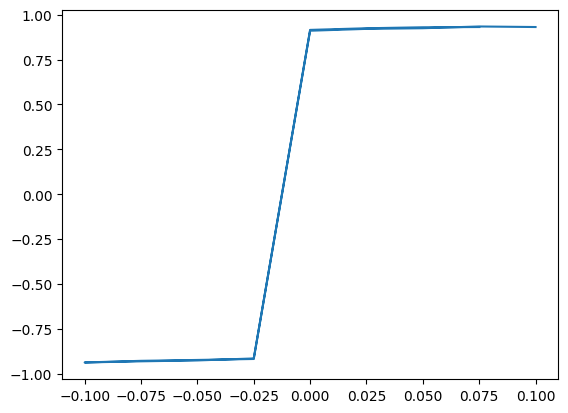

In [48]:
plt.plot(fields, magn)